# Fitzhugh-Nagumo simplified action-potential model

This example shows how the [Fitzhugh-Nagumo simplified action potential (AP) model](http://pints.readthedocs.io/en/latest/toy/fitzhugh_nagumo_model.html) can be used.

The model is based on a simplification and state-reduction of the original squid axon model by Hodgkind and Huxley.
It has two state variables, a voltage-like variable and a recovery variable.


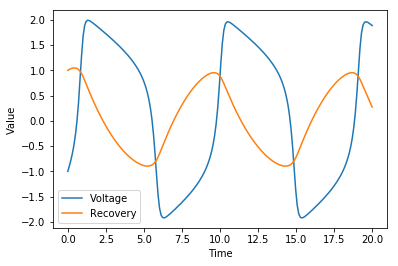

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy

# Create a model
model = pints.toy.FitzhughNagumoModel()

# Run a simulation
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 20, 200)
values = model.simulate(parameters, times)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, values)
plt.legend(['Voltage', 'Recovery'])
plt.show()

With these parameters, the model creates wide AP waveforms that are more reminiscent of muscle cells than neurons.

We now set up a simple optimisation problem with the model.

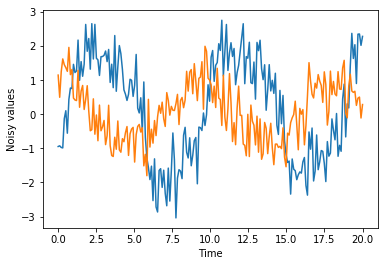

In [3]:
# First add some noise
sigma = 0.5
noisy = values + np.random.normal(0, sigma, values.shape)

# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Noisy values')
plt.plot(times, noisy)
plt.show()

Next, we set up a problem. Because this model has multiple outputs (2), we use a [MultiOutputProblem](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#multi-output-problem).

In [4]:
problem = pints.MultiOutputProblem(model, times, noisy)
score = pints.SumOfSquaresError(problem)

Finally, we choose a wide set of boundaries and run!

In [5]:
# Select boundaries
boundaries = pints.RectangularBoundaries([0., 0., 0.], [10., 10., 10.])

# Select a starting point
x0 = [1, 1, 1]

# Perform an optimization
found_parameters, found_value = pints.optimise(score, x0, boundaries=boundaries)

print('Score at true solution:')
print(score(parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(parameters[k]))

Minimising error measure
Using Covariance Matrix Adaptation Evolution Strategy (CMA-ES)
Running in sequential mode.
Population size: 7
Iter. Eval. Best      Time m:s
0     7      194.0896   0:00.1
1     14     194.0896   0:00.2
2     21     194.0896   0:00.2
3     28     194.0896   0:00.3
20    147    102.0824   0:01.8
40    287    101.9954   0:03.9
60    427    101.9897   0:06.0
80    567    101.9897   0:08.1
100   707    101.9897   0:10.0
120   847    101.9897   0:12.1
140   987    101.9897   0:14.2
160   1127   101.9897   0:16.4
180   1267   101.9897   0:18.7
200   1407   101.9897   0:20.7
220   1547   101.9897   0:22.7
240   1687   101.9897   0:24.7
260   1827   101.9897   0:26.8
280   1967   101.9897   0:28.9
293   2051   101.9897   0:30.1
Halting: No significant change for 200 iterations.
Score at true solution:
102.75699877371005
Found solution:          True parameters:
 1.02626429600816971e-01     1.00000000000000006e-01
 6.01554291785290296e-01     5.00000000000000000e-01
 2.

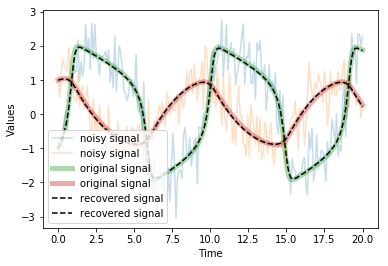

In [6]:
# Plot the results
plt.figure()
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, noisy, '-', alpha=0.25, label='noisy signal')
plt.plot(times, values, alpha=0.4, lw=5, label='original signal')
plt.plot(times, problem.evaluate(found_parameters), 'k--', label='recovered signal')
plt.legend()
plt.show()

This shows the parameters are not retrieved entirely correctly, but the traces still strongly overlap.

## Sampling with Monomial-gamma HMC

The Fitzhugh-Nagumo model has sensitivities calculated by the forward sensitivities approach, so we can use samplers that use gradients (although they will be slower per iteration; although perhaps not by ESS per second!), like Monomial-gamma HMC.

In [7]:
problem = pints.MultiOutputProblem(model, times, noisy)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0, 0, 0, 0, 0],
    [10, 10, 10, 20, 20]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
real_parameters1 = np.array(parameters + [sigma, sigma])
xs = [
    real_parameters1 * 1.1,
    real_parameters1 * 0.9,
    real_parameters1 * 1.15,
    real_parameters1 * 1.5,
]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 4, xs, method=pints.MonomialGammaHamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(200)
mcmc.set_log_interval(1)

# Run in parallel
mcmc.set_parallel(True)

for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size([0.05, 0.2, 0.2, 0.1, 0.1])
    sampler.set_leapfrog_steps(10)

# Run!
print('Running...')
chains = mcmc.run()
print('Done!')

Running...
Using Monomial-Gamma Hamiltonian Monte Carlo
Generating 4 chains.
Running in parallel with 4 worker processess.


/home/michael/dev/pints/pints/_mcmc/_monomial_gamma_hamiltonian.py:272: RuntimeWarning: overflow encountered in exp
  1.0 + np.exp(c * self._g(p, a, m)))


Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:11.4
1     44     0.333     0.333     0.333     0.333      0:13.7
2     84     0.5       0.5       0.5       0.5        0:16.0
3     124    0.6       0.6       0.6       0.6        0:18.3
4     164    0.667     0.667     0.667     0.667      0:20.7
5     204    0.714     0.714     0.714     0.571      0:23.1
6     244    0.75      0.75      0.75      0.625      0:25.6
7     284    0.778     0.778     0.778     0.556      0:28.0
8     324    0.8       0.8       0.8       0.5        0:30.4
9     364    0.727     0.818     0.818     0.455      0:32.7
10    404    0.75      0.833     0.833     0.417      0:35.0
11    444    0.769     0.846     0.846     0.385      0:37.2
12    484    0.786     0.857     0.857     0.357      0:39.5
13    524    0.8       0.867     0.867     0.333      0:41.7
14    564    0.8125    0.875     0.875     0.375      0:44.1
15    604    0.824     0

134   5364   0.963     0.978     0.971     0.897      6:12.2
135   5404   0.964     0.978     0.971     0.898      6:16.0
136   5444   0.964     0.978     0.971     0.899      6:19.8
137   5484   0.964     0.978     0.971223  0.899      6:23.3
138   5524   0.964     0.979     0.971     0.9        6:27.0
139   5564   0.964539  0.979     0.972     0.901      6:30.5
140   5604   0.965     0.979     0.971831  0.901      6:34.0
141   5644   0.958042  0.979021  0.972028  0.902      6:37.5
142   5684   0.958     0.979     0.972     0.903      6:41.0
143   5724   0.959     0.979     0.972     0.903      6:44.5
144   5764   0.959     0.979     0.973     0.904      6:47.8
145   5804   0.959     0.98      0.973     0.905      6:51.0
146   5844   0.959     0.98      0.972973  0.905      6:54.5
147   5884   0.96      0.98      0.973     0.906      6:57.8
148   5924   0.96      0.98      0.973     0.907      7:01.4
149   5964   0.96      0.98      0.974     0.907      7:04.9
150   6004   0.961     0

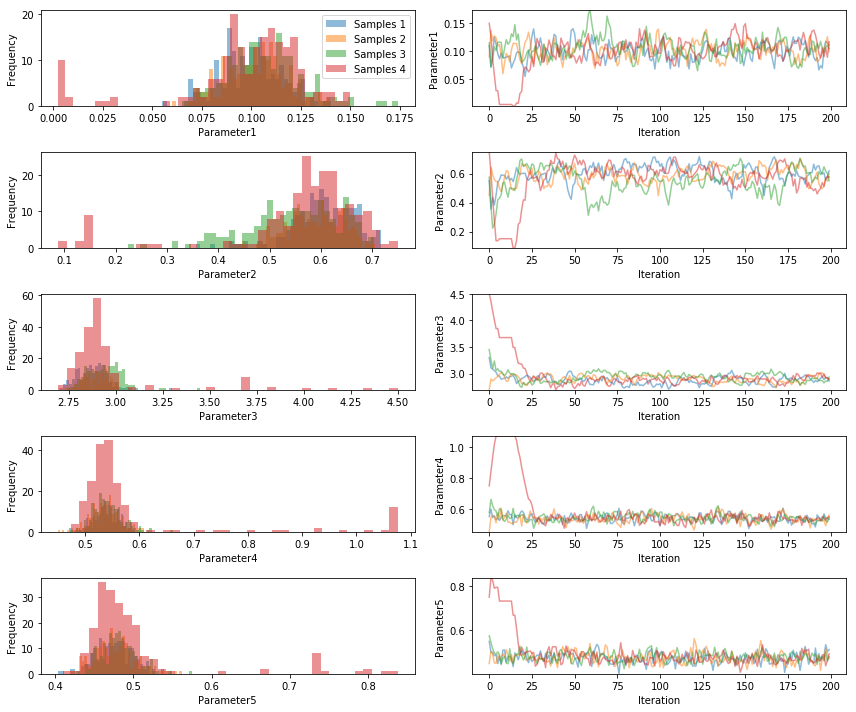

In [8]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Print results.

In [9]:
results = pints.MCMCSummary(
    chains=chains, 
    time=mcmc.time(), 
    parameter_names=['a', 'b', 'c', 'sigma_V', 'sigma_R'],
)
print(results)

param    mean    std.    2.5%    25%    50%    75%    97.5%    rhat    ess     ess per sec.
-------  ------  ------  ------  -----  -----  -----  -------  ------  ------  --------------
a        0.10    0.02    0.06    0.09   0.10   0.11   0.14     1.06    120.52  0.21
b        0.58    0.09    0.34    0.54   0.59   0.64   0.70     1.05    68.37   0.12
c        2.92    0.16    2.75    2.84   2.90   2.95   3.24     1.06    63.42   0.11
sigma_V  0.55    0.08    0.49    0.52   0.54   0.56   0.76     1.12    138.03  0.24
sigma_R  0.48    0.05    0.43    0.46   0.48   0.49   0.55     1.08    159.35  0.28


Plot the few posterior predictive simulations versus data.

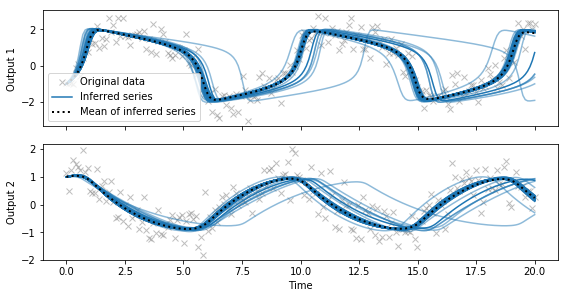

In [10]:
import pints.plot
pints.plot.series(np.vstack(chains), problem)
plt.show()